In [5136]:
import numpy as np
import json
import random
import argparse
import os

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.distributions.multivariate_normal as mvn
from torch.nn.utils import spectral_norm

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PIL import Image, ImageDraw

In [5137]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5138]:
seed = 1123
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

Random Seed:  1123


In [5139]:
# batch_size = args.batch_size
# lrd = args.learning_rate_disc
# lrg = args.learning_rate_gen
# epochs = args.epochs

batch_size = 256
lr = 1e-4
epochs = 10

betas = [0.5, 0.999]

# Check for cuda
use_cuda = torch.cuda.is_available()

EPS = 1e-6

In [5140]:
class Encoder(nn.Module):
    def __init__(self, in_channels = 1, num_hiddens = 128):
        super(Encoder, self).__init__()

        self.num_hiddens = num_hiddens


        self._conv_0 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//4,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self.bn0 = nn.BatchNorm2d(num_hiddens//4)

        self._conv_1 = nn.Conv2d(in_channels=num_hiddens//4,
                                 out_channels=num_hiddens//4,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hiddens//4)

        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//4,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)

        self.bn2 = nn.BatchNorm2d(num_hiddens//2)

        self._conv_3 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)

        self.bn3 = nn.BatchNorm2d(num_hiddens//2)

    def forward(self, inputs):

        x = F.leaky_relu(self.bn0(self._conv_0(inputs)), 0.2, inplace=True)

        x = self.bn1(self._conv_1(x))
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self.bn2(self._conv_2(x))
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self.bn3(self._conv_3(x))
        x = F.leaky_relu(x, 0.2, inplace=True)


        return x.view(-1, self.num_hiddens*8)

In [5141]:
class nbnEncoder(nn.Module):
    def __init__(self, in_channels = 1, num_hiddens = 128):
        super(nbnEncoder, self).__init__()
        
        self.num_hiddens = num_hiddens

        
        self._conv_0 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//4,
                                 kernel_size=4,
                                 stride=2, padding=1)
        
        self._conv_1 = nn.Conv2d(in_channels=num_hiddens//4,
                                 out_channels=num_hiddens//4,
                                 kernel_size=4,
                                 stride=2, padding=1)

        
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//4,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        
        
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)

    def forward(self, inputs):

        x = F.leaky_relu(self._conv_0(inputs), 0.2, inplace=True)

        x = self._conv_1(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._conv_2(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._conv_3(x)
        x = F.leaky_relu(x, 0.2, inplace=True)


        return x.view(-1, self.num_hiddens*8)

In [5142]:
class Latents_z1(nn.Module):
    def __init__(self, hidden_dim = 128, z1 = 5):
        super(Latents_z1, self).__init__()

        self.hidden_dim = hidden_dim

        self.z1 = z1

        self._fc1 = nn.Linear(1024, hidden_dim * 2)
        self.fcbn1 = nn.BatchNorm1d(hidden_dim*2)
        self._fc2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fcbn2 = nn.BatchNorm1d(hidden_dim)

        self.fc_mean = nn.Linear(hidden_dim, self.z1)
        self.fc_log_var = nn.Linear(hidden_dim, self.z1)

    def forward(self, inputs):

        x = self.fcbn1(self._fc1(inputs))
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self.fcbn2(self._fc2(x))
        x = F.leaky_relu(x, 0.2, inplace=True)

        mean = self.fc_mean(x)
        logvar = self.fc_log_var(x)

        return mean, logvar

In [5143]:
class nbnLatents_z1(nn.Module):
    def __init__(self, hidden_dim = 128, z1 = 5):
        super(nbnLatents_z1, self).__init__()

        self.hidden_dim = hidden_dim

        self.z1 = z1

        self._fc1 = nn.Linear(1024, hidden_dim * 2)

        self._fc2 = nn.Linear(hidden_dim * 2, hidden_dim)

        self.fc_mean = nn.Linear(hidden_dim, self.z1)
        self.fc_log_var = nn.Linear(hidden_dim, self.z1)

    def forward(self, inputs):

        x = self._fc1(inputs)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._fc2(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        mean = self.fc_mean(x)
        logvar = self.fc_log_var(x)

        return mean, logvar


In [5144]:
class Latents_z2(nn.Module):
    def __init__(self, hidden_dim = 128, z2 = 10):
        super(Latents_z2, self).__init__()

        self.hidden_dim = hidden_dim

        self.z2 = z2

        self._fc1 = nn.Linear(1024, hidden_dim * 2)
        self.fcbn1 = nn.BatchNorm1d(hidden_dim*2)

        self._fc2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fcbn2 = nn.BatchNorm1d(hidden_dim)

        self.fc_mean = nn.Linear(hidden_dim, self.z2)
        self.fc_log_var = nn.Linear(hidden_dim, self.z2)

    def forward(self, inputs):

        x = self.fcbn1(self._fc1(inputs))
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self.fcbn2(self._fc2(x))
        x = F.leaky_relu(x, 0.2, inplace=True)

        mean = self.fc_mean(x)
        logvar = self.fc_log_var(x)

        return mean, logvar

In [5145]:
class nbnLatents_z2(nn.Module):
    def __init__(self, hidden_dim = 128, z2 = 10):
        super(nbnLatents_z2, self).__init__()

        self.hidden_dim = hidden_dim

        self.z2 = z2

        self._fc1 = nn.Linear(1024, hidden_dim * 2)

        self._fc2 = nn.Linear(hidden_dim * 2, hidden_dim)

        self.fc_mean = nn.Linear(hidden_dim, self.z2)
        self.fc_log_var = nn.Linear(hidden_dim, self.z2)

    def forward(self, inputs):

        x = self._fc1(inputs)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._fc2(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        mean = self.fc_mean(x)
        logvar = self.fc_log_var(x)

        return mean, logvar




In [5146]:
class Discriminator(nn.Module):
    def __init__(self, hidden_dim = 64):
        super().__init__()
        # hidden dim has to be smaller (32)
        
        # has to have linear layers
        self._fc1 = spectral_norm(nn.Linear(1024, hidden_dim * 2))
#         self.bn = nn.BatchNorm1d(hidden_dim*2)
        self._fc2 = nn.Linear(hidden_dim*2,1)

    def forward(self, x):
        x = F.leaky_relu(self._fc1(x), 0.2, inplace=True)
        output = torch.sigmoid(self._fc2(x))

        return output.view(-1)

In [5147]:
class Discriminator1(nn.Module):
    def __init__(self, hidden_dim = 64, num_hiddens=128, in_channels=1):
        super().__init__()
        # hidden dim has to be smaller (32)
        self.num_hiddens = num_hiddens


        self._conv_0 = spectral_norm(nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//4,
                                 kernel_size=4,
                                 stride=2, padding=1))

        self._conv_1 = spectral_norm(nn.Conv2d(in_channels=num_hiddens//4,
                                 out_channels=num_hiddens//4,
                                 kernel_size=4,
                                 stride=2, padding=1))


        self._conv_2 = spectral_norm(nn.Conv2d(in_channels=num_hiddens//4,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1))


        self._conv_3 = spectral_norm(nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1))

        # has to have linear layers
        self._fc1 = spectral_norm(nn.Linear(1024, hidden_dim * 2))
#         self.bn = nn.BatchNorm1d(hidden_dim*2)
        self._fc2 = nn.Linear(hidden_dim*2,1)

    def forward(self, inputs):
        x = F.leaky_relu(self._conv_0(inputs), 0.2, inplace=True)

        x = self._conv_1(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._conv_2(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._conv_3(x)
        x = F.leaky_relu(x, 0.2, inplace=True)
        x = x.view(-1, self.num_hiddens*8)


        x = F.leaky_relu(self._fc1(x), 0.2, inplace=True)
        output = torch.sigmoid(self._fc2(x))

        return output.view(-1)

In [5148]:
class Decoder(nn.Module):
    def __init__(self, latent_dim = 10, hidden_dim = 256, num_hiddens = 128):
        super(Decoder, self).__init__()
        
        self.num_hiddens = num_hiddens
        
        self._fc1 = nn.Linear(latent_dim, hidden_dim//2)
        self.fcbn1 = nn.BatchNorm1d(hidden_dim//2)
        
        self._fc2 = nn.Linear(hidden_dim//2, 1024)
        self.fcbn2 = nn.BatchNorm1d(1024)
        
#         self._tconv1 = nn.ConvTranspose2d(1024, num_hiddens*2, 1, 1)
#         self.bn1 = nn.BatchNorm2d(num_hiddens*2)
        
        # num_hiddens is 256
        
        # the exact inverse of the encoder
        self._tconv2 = nn.ConvTranspose2d(num_hiddens//2, num_hiddens//2, kernel_size=4, stride=2, padding =1)
        self.bn2 = nn.BatchNorm2d(num_hiddens//2)
        
        self._tconv3 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                out_channels=num_hiddens//4,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(num_hiddens//4)
        
        self._tconv4 = nn.ConvTranspose2d(in_channels=num_hiddens//4, 
                                                out_channels=num_hiddens//4,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(num_hiddens//4)
        


        self._tconv5 = nn.ConvTranspose2d(in_channels=num_hiddens//4, 
                                                out_channels=1,
                                                kernel_size=4, 
                                                stride=2, padding=1)

        
    def forward(self, inputs):
        x = self.fcbn1(self._fc1(inputs))
        x = F.leaky_relu(x, 0.2, inplace=True)
        
        
        x = self.fcbn2(self._fc2(x))
        x = F.leaky_relu(x, 0.2, inplace=True)
        
#         x = self.bn1(self._tconv1(x.view(-1,64,4,4)))
#         x = F.leaky_relu(x, 0.2, inplace=True)
        
        x = self.bn2(self._tconv2(x.view(-1,64,4,4)))
        x = F.leaky_relu(x, 0.2, inplace=True)
        
        x = self.bn3(self._tconv3(x))
        x = F.leaky_relu(x, 0.2, inplace=True)
        
        x = self.bn4(self._tconv4(x))
        x = F.leaky_relu(x, 0.2, inplace=True)
        
        return torch.sigmoid(self._tconv5(x))
    


In [5149]:
class nbnDecoder(nn.Module):
    def __init__(self, latent_dim = 10, hidden_dim = 256, num_hiddens = 128, out_channels=1):
        super(nbnDecoder, self).__init__()

        self.num_hiddens = num_hiddens

        self._fc1 = nn.Linear(latent_dim, hidden_dim//2)

        self._fc2 = nn.Linear(hidden_dim//2, 1024)

        # num_hiddens is 256

        # the exact inverse of the encoder
        self._tconv2 = nn.ConvTranspose2d(num_hiddens//2, num_hiddens//2, kernel_size=4, stride=2, padding =1)

        self._tconv3 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=num_hiddens//4,
                                                kernel_size=4,
                                                stride=2, padding=1)

        self._tconv4 = nn.ConvTranspose2d(in_channels=num_hiddens//4,
                                                out_channels=num_hiddens//4,
                                                kernel_size=4,
                                                stride=2, padding=1)


        self._tconv5 = nn.ConvTranspose2d(in_channels=num_hiddens//4,
                                                out_channels=out_channels,
                                                kernel_size=4,
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._fc1(inputs)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._fc2(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._tconv2(x.view(-1,64,4,4))
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._tconv3(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        x = self._tconv4(x)
        x = F.leaky_relu(x, 0.2, inplace=True)

        return torch.sigmoid(self._tconv5(x))

In [5150]:
class VAE(nn.Module):
    def __init__(self, img_size = (1,64,64), enc_hidden = 256, lat_hidden = 64, dis_hidden = 32, z1 = 5, z2 = 5, dec_hidden = 256, use_cuda=False):

        super(VAE, self).__init__()
        self.use_cuda = use_cuda

        # Parameters
        self.img_size = img_size
        self.num_pixels = img_size[1] * img_size[2]
        self.z1 = z1
        self.z2 = z2
        self.channels = img_size[0]
    
        # Define the encoder
        self.img_to_features = nbnEncoder(in_channels=self.channels)

        self.latent_encoder_z1 = nbnLatents_z1(z1=z1)
        #for _ in range(z1):
        #    self.latent_encoder_z1.append(nbnLatents_z1(z1=1))
            
        # Define the latent encoder
        
        self.latent_encoder_z2 = nbnLatents_z2(z2=z2)
        # Define the Discriminator
        self.discriminator = Discriminator()

        # Define decoder
        self.features_to_img = nbnDecoder(z1+z2)
        
    def representation_function(self,x):
        features = self.img_to_features(x)
        latent_disc = self.latent(features, num_active=1)
        return latent_disc[0]

    def forward(self, data):
        encoded = self.encode(data)
        latent_disc = self.latent(encoded)
        recons = self.decode(latent_disc[0])
        return recons, latent_disc

    def encoder(self,x):
        features = self.img_to_features(x)
        latent_disc_z1 = self.latent_encoder_z1(features)
        latent_disc_z2 = self.latent_encoder_z2(features)
        latent_disc = torch.cat((latent_disc_z1[0], latent_disc_z2[0]),1)
        return latent_disc_z1

    def init_weights(self):
        self.img_to_features.apply(self.weights_init)
        self.discriminator.apply(self.weights_init)
        self.features_to_img.apply(self.weights_init)

    def weights_init(self,m):

        if(type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif(type(m) == nn.BatchNorm2d):
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

    def encode(self, x):

        # Encode image to hidden features
        features = self.img_to_features(x)
        return features

    def zdiscriminate(self,z):
        return self.zdiscriminator(z)
    
    def latent(self,x):
        latent_disc_z1_mean, latent_disc_z1_logvar = self.latent_encoder_z1(x)
        latent_disc_z2_mean, latent_disc_z2_logvar = self.latent_encoder_z2(x)
        latent_disc_mean = torch.cat((latent_disc_z1_mean, latent_disc_z2_mean),1)
        latent_disc_var = torch.cat((latent_disc_z1_logvar, latent_disc_z2_logvar),1)
        return [latent_disc_mean, latent_disc_var]

    def latent_z1(self,x):

        z1_mean = []
        z1_logvar = []
        for i in range(self.z1):
            mu, logvar = self.latent_encoder_z1[i](x)
            z1_mean.append(mu)
            z1_logvar.append(logvar)
        #z1_mean.append(torch.zeros((x.shape[0],self.z1-num_active),requires_grad=False).to(x.device))
        #z1_logvar.append(torch.zeros((x.shape[0],self.z1-num_active),requires_grad=False).to(x.device))

        #for i in range(num_active,self.z1):
        #    with torch.no_grad():
        #        mu, logvar = self.latent_encoder_z1[i](x)
        #        z1_mean.append(mu)
        #        z1_logvar.append(logvar)
        latent_disc_z1_mean = torch.cat(z1_mean,dim=1)
        latent_disc_z1_logvar = torch.cat(z1_logvar,dim=1)

        return latent_disc_z1_mean, latent_disc_z1_logvar

    def latent_z2(self,x):

        latent_disc = self.latent_encoder_z2(x)
        return latent_disc


    def discriminate(self,x):

        return self.discriminator(x)

    def cr(self,x):

        return self.crd(x)

    def decode(self, latent_sample):

        return self.features_to_img(latent_sample)

    def sample_recons(self, latent_disc):
        return latent_disc[0]

    def sample_gen(self, latent_disc):
        mean, logvar = latent_disc
        std = torch.exp(0.5 * logvar)
        eps = torch.zeros(std.size()).normal_()
        if self.use_cuda:
            eps = eps.cuda()
        return mean + std * eps

In [5151]:
if __name__ == "__main__":
    batch_size = 256
    img_size = (1,64,64)
    model = VAE(img_size=img_size, z1=10, z2=10, use_cuda=use_cuda)
    if use_cuda:
        model.cuda()
    checkpoint = torch.load('crabweights_e50_d20_g60_lrg0.0001_lrd0.0001_bs128_z210_intperm_red10.0_z2recons1_real0_ep10',map_location=torch.device('cpu'))
    plots = ['samples', 'reconstruct-traverse']
    loss_file = 'crablosses_e50_d20_g60_lrg0.0001_lrd0.0001_bs128_z210_intperm_red10.0_z2recons1_real0_ep10.json'
    
    
    #

In [5152]:
## see if this can be used 

# test_data = torch.from_numpy(np.load('tinydsprites_s1_o_y.npy')).float()
test_data = torch.from_numpy(np.load('../dsprites/dsprites_data_test.npy')).unsqueeze(1).float()
test_labels = torch.from_numpy(np.load('../dsprites/dsprites_latent_values_test.npy')).float()
# test_labels = torch.from_numpy(np.load('tinydsplabels_s1_o.npy')).float()


test_dataset = torch.utils.data.TensorDataset(test_data,test_labels)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 16, shuffle=True,
drop_last=True)


In [5153]:
################## yann visualizations ########################################

In [5154]:
class Visualizer():
    def __init__(self, model, model_dir, loss_file, 
                 save_images=True,
                 loss_of_interest=None,
                 display_loss_per_dim=False,
                 max_traversal=0.475,  # corresponds to ~2 for standard normal
                 upsample_factor=1):
        """
        Visualizer is used to generate images of samples, reconstructions,
        latent traversals and so on of the trained model.
        Parameters
        ----------
        model : disvae.vae.VAE
        dataset : str
            Name of the dataset.
        model_dir : str
            The directory that the model is saved to and where the images will
            be stored.
        save_images : bool, optional
            Whether to save images or return a tensor.
        loss_of_interest : str, optional
            The loss type (as saved in the log file) to order the latent dimensions by and display.
        display_loss_per_dim : bool, optional
            if the loss should be included as text next to the corresponding latent dimension images.
        max_traversal: float, optional
            The maximum displacement induced by a latent traversal. Symmetrical
            traversals are assumed. If `m>=0.5` then uses absolute value traversal,
            if `m<0.5` uses a percentage of the distribution (quantile).
            E.g. for the prior the distribution is a standard normal so `m=0.45` c
            orresponds to an absolute value of `1.645` because `2m=90%%` of a
            standard normal is between `-1.645` and `1.645`. Note in the case
            of the posterior, the distribution is not standard normal anymore.
        upsample_factor : floar, optional
            Scale factor to upsample the size of the tensor
        """
        self.model = model
        self.device = next(self.model.parameters()).device
        self.latent_dim = self.model.z1 + self.model.z2
        self.max_traversal = max_traversal
        self.save_images = save_images
        self.model_dir = model_dir 
        self.dataset = 'dsprites'
        self.upsample_factor = upsample_factor
        if loss_of_interest is not None:
            # get this from your loss file
            self.losses = read_loss_from_file(loss_file)

    def _get_traversal_range(self, mean=0, std=1):
        """Return the corresponding traversal range in absolute terms."""
        max_traversal = self.max_traversal

        if max_traversal < 0.5:
            max_traversal = (1 - 2 * max_traversal) / 2  # from 0.45 to 0.05
            max_traversal = stats.norm.ppf(max_traversal, loc=mean, scale=std)  # from 0.05 to -1.645

        # symmetrical traversals
        return (-1 * max_traversal, max_traversal)

    def _traverse_line(self, idx, n_samples, data=None):
        """Return a (size, latent_size) latent sample, corresponding to a traversal
        of a latent variable indicated by idx.
        Parameters
        ----------
        idx : int
            Index of continuous dimension to traverse. If the continuous latent
            vector is 10 dimensional and idx = 7, then the 7th dimension
            will be traversed while all others are fixed.
        n_samples : int
            Number of samples to generate.
        data : torch.Tensor or None, optional
            Data to use for computing the posterior. Shape (N, C, H, W). If
            `None` then use the mean of the prior (all zeros) for all other dimensions.
        """
        if data is None:
            # mean of prior for other dimensions
            samples = torch.zeros(n_samples, self.latent_dim)
            traversals = torch.linspace(*self._get_traversal_range(), steps=n_samples)

        else:
            if data.size(0) > 1:
                raise ValueError("Every value should be sampled from the same posterior, but {} datapoints given.".format(data.size(0)))

            with torch.no_grad():
                post_mean, post_logvar = self.model.latent(self.model.encode(data.to(self.device)))
                samples = self.model.sample_gen([post_mean, post_logvar])
                samples = samples.cpu().repeat(n_samples, 1)
                post_mean_idx = post_mean.cpu()[0, idx]
                post_std_idx = torch.exp(post_logvar / 2).cpu()[0, idx]

            # travers from the gaussian of the posterior in case quantile
            traversals = torch.linspace(*self._get_traversal_range(mean=post_mean_idx,
                                                                   std=post_std_idx),
                                        steps=n_samples)

        for i in range(n_samples):
            samples[i, idx] = traversals[i]

        return samples

    def _save_or_return(self, to_plot, size, filename, is_force_return=False):
        """Create plot and save or return it."""
        to_plot = F.interpolate(to_plot, scale_factor=self.upsample_factor)

        if size[0] * size[1] != to_plot.shape[0]:
            raise ValueError("Wrong size {} for datashape {}".format(size, to_plot.shape))

        # `nrow` is number of images PER row => number of col
        kwargs = dict(nrow=size[1], pad_value=1)
        if self.save_images and not is_force_return:
            filename = os.path.join(self.model_dir, filename)
            save_image(to_plot, filename, **kwargs)
        else:
            return make_grid_img(to_plot, **kwargs)

    def _decode_latents(self, latent_samples):
        """Decodes latent samples into images.
        Parameters
        ----------
        latent_samples : torch.autograd.Variable
            Samples from latent distribution. Shape (N, L) where L is dimension
            of latent distribution.
        """
        latent_samples = latent_samples.to(self.device)
        return self.model.decode(latent_samples).cpu()

    def generate_samples(self, size=(8, 8)):
        """Plot generated samples from the prior and decoding.
        Parameters
        ----------
        size : tuple of ints, optional
            Size of the final grid.
        """
        prior_samples = torch.randn(size[0] * size[1], self.latent_dim)
        generated = self._decode_latents(prior_samples)
        return self._save_or_return(generated.data, size, PLOT_NAMES["generate_samples"])

    def data_samples(self, data, size=(8, 8)):
        """Plot samples from the dataset
        Parameters
        ----------
        data : torch.Tensor
            Data to be reconstructed. Shape (N, C, H, W)
        size : tuple of ints, optional
            Size of the final grid.
        """
        data = data[:size[0] * size[1], ...]
        return self._save_or_return(data, size, PLOT_NAMES["data_samples"])

    def reconstruct(self, data, size=(8, 8), is_original=True, is_force_return=False):
        """Generate reconstructions of data through the model.
        Parameters
        ----------
        data : torch.Tensor
            Data to be reconstructed. Shape (N, C, H, W)
        size : tuple of ints, optional
            Size of grid on which reconstructions will be plotted. The number
            of rows should be even when `is_original`, so that upper
            half contains true data and bottom half contains reconstructions.contains
        is_original : bool, optional
            Whether to exclude the original plots.
        is_force_return : bool, optional
            Force returning instead of saving the image.
        """
        if is_original:
            if size[0] % 2 != 0:
                raise ValueError("Should be even number of rows when showing originals not {}".format(size[0]))
            n_samples = size[0] // 2 * size[1]
        else:
            n_samples = size[0] * size[1]

        with torch.no_grad():
            originals = data.to(self.device)[:n_samples, ...]
            recs,_ = self.model(originals)

        originals = originals.cpu()
        recs = recs.view(-1, *self.model.img_size).cpu()

        to_plot = torch.cat([originals, recs]) if is_original else recs
        return self._save_or_return(to_plot, size, PLOT_NAMES["reconstruct"],
                                    is_force_return=is_force_return)

    def traversals(self,
                   data=None,
                   is_reorder_latents=False,
                   n_per_latent=8,
                   n_latents=None,
                   is_force_return=False):
        """Plot traverse through all latent dimensions (prior or posterior) one
        by one and plots a grid of images where each row corresponds to a latent
        traversal of one latent dimension.
        Parameters
        ----------
        data : bool, optional
            Data to use for computing the latent posterior. If `None` traverses
            the prior.
        n_per_latent : int, optional
            The number of points to include in the traversal of a latent dimension.
            I.e. number of columns.
        n_latents : int, optional
            The number of latent dimensions to display. I.e. number of rows. If `None`
            uses all latents.
        is_reorder_latents : bool, optional
            If the latent dimensions should be reordered or not
        is_force_return : bool, optional
            Force returning instead of saving the image.
        """
        n_latents = n_latents if n_latents is not None else self.model.latent_dim
        latent_samples = [self._traverse_line(dim, n_per_latent, data=data)
                          for dim in range(self.latent_dim)]
        decoded_traversal = self._decode_latents(torch.cat(latent_samples, dim=0))

        if is_reorder_latents:
            n_images, *other_shape = decoded_traversal.size()
            n_rows = n_images // n_per_latent
            decoded_traversal = decoded_traversal.reshape(n_rows, n_per_latent, *other_shape)
            decoded_traversal = sort_list_by_other(decoded_traversal, self.losses)
            decoded_traversal = torch.stack(decoded_traversal, dim=0)
            decoded_traversal = decoded_traversal.reshape(n_images, *other_shape)
            
        decoded_traversal = decoded_traversal[range(n_per_latent * n_latents), ...]

        size = (n_latents, n_per_latent)
        sampling_type = "prior" if data is None else "posterior"
        filename = "{}_{}".format(sampling_type, PLOT_NAMES["traversals"])

        return self._save_or_return(decoded_traversal.data, size, filename,
                                    is_force_return=is_force_return)

    def reconstruct_traverse(self, data,
                             is_posterior=True,
                             n_per_latent=10,
                             n_latents=None,
                             is_show_text=True):
        """
        Creates a figure whith first row for original images, second are
        reconstructions, rest are traversals (prior or posterior) of the latent
        dimensions.
        Parameters
        ----------
        data : torch.Tensor
            Data to be reconstructed. Shape (N, C, H, W)
        n_per_latent : int, optional
            The number of points to include in the traversal of a latent dimension.
            I.e. number of columns.
        n_latents : int, optional
            The number of latent dimensions to display. I.e. number of rows. If `None`
            uses all latents.
        is_posterior : bool, optional
            Whether to sample from the posterior.
        is_show_text : bool, optional
            Whether the KL values next to the traversal rows.
        """
        n_latents = n_latents if n_latents is not None else self.model.latent_dim

        reconstructions = self.reconstruct(data[:2 * n_per_latent, ...],
                                           size=(2, n_per_latent),
                                           is_force_return=True)
        traversals = self.traversals(data=data[3:4, ...] if is_posterior else None,
                                     is_reorder_latents=True,
                                     n_per_latent=n_per_latent,
                                     n_latents=n_latents,
                                     is_force_return=True)

        concatenated = np.concatenate((reconstructions, traversals), axis=0)
        concatenated = Image.fromarray(concatenated)
        concatenated.show()

        if is_show_text:
            losses = sorted(self.losses, reverse=True)[:n_latents]
            labels = ['orig', 'recon'] + ["KL={:.4f}".format(l) for l in losses]
            concatenated = add_labels(concatenated, labels)

        filename = os.path.join(self.model_dir, PLOT_NAMES["reconstruct_traverse"])
        concatenated.save(filename)

In [5155]:
def load_weights(model, checkpoint):
    model.img_to_features.load_state_dict(checkpoint['encoder'])
    model.latent_encoder_z1.load_state_dict(checkpoint['latent_z1'])
    model.latent_encoder_z2.load_state_dict(checkpoint['latent_z2'])
    model.features_to_img.load_state_dict(checkpoint['decoder'])
    model.eval()
    return model

def make_grid_img(tensor, **kwargs):
    """Converts a tensor to a grid of images that can be read by imageio.
    Notes
    -----
    * from in https://github.com/pytorch/vision/blob/master/torchvision/utils.py
    Parameters
    ----------
    tensor (torch.Tensor or list): 4D mini-batch Tensor of shape (B x C x H x W)
        or a list of images all of the same size.
    kwargs:
        Additional arguments to `make_grid_img`.
    """
    grid = make_grid(tensor, **kwargs)
    img_grid = grid.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0)
    img_grid = img_grid.to('cpu', torch.uint8).numpy()
    return img_grid


# def get_samples
def get_samples(dataset, num_samples, idcs=[]):
    """ Generate a number of samples from the dataset.
    Parameters
    ----------
    dataset : str
        The name of the dataset.
    num_samples : int, optional
        The number of samples to load from the dataset
    idcs : list of ints, optional
        List of indices to of images to put at the begning of the samples.
    """
    data_loader = torch.utils.data.DataLoader(dataset,
                                  batch_size=1,
                                  shuffle=idcs is None)

    idcs += random.sample(range(len(data_loader.dataset)), num_samples - len(idcs))
    samples = torch.stack([data_loader.dataset[i][0] for i in idcs], dim=0)
    print("Selected idcs: {}".format(idcs))

    return samples

def sort_list_by_other(to_sort, other, reverse=True):
    """Sort a list by an other."""
    return [el for _, el in sorted(zip(other, to_sort), reverse=reverse)]

def read_loss_from_file(loss_file):
    with open(loss_file) as f:
        data = json.load(f)
    kllist =[]
    for key in list(data):
        if 'kl_' in key:
            if 'kl_z' not in key:
                kllist.append(np.sum(data[key][-100:])/100)
    return kllist

def add_labels(input_image, labels):
    """Adds labels next to rows of an image.
    Parameters
    ----------
    input_image : image
        The image to which to add the labels
    labels : list
        The list of labels to plot
    """
    new_width = input_image.width + 100
    new_size = (new_width, input_image.height)
    new_img = Image.new("RGB", new_size, color='white')
    new_img.paste(input_image, (0, 0))
    draw = ImageDraw.Draw(new_img)

    for i, s in enumerate(labels):
        draw.text(xy=(new_width - 100 + 0.005,
                      int((i / len(labels) + 1 / (2 * len(labels))) * input_image.height)),
                  text=s,
                  fill=(0, 0, 0))

    return new_img

In [5156]:
PLOT_NAMES = dict(generate_samples="samples.png",
                  data_samples="data_samples.png",
                  reconstruct="reconstruct.png",
                  traversals="traversals.png",
                  reconstruct_traverse="reconstruct_traverse.png")
n_rows = 10
#n_rows = model.latent_dim
n_cols = 10

#model = VAE(img_size=img_size, z1=2, z2=10, use_cuda=use_cuda)
model = load_weights(model, checkpoint)

dataset = 'dsprites'
    
viz = Visualizer(model=model,
                 model_dir='',
                 max_traversal=2,
                 loss_of_interest='kl_loss', loss_file=loss_file,
                 upsample_factor=1) 
size = (n_rows, n_cols)
# same samples for all plots: sample max then take first `x`data  for all plots
num_samples = n_cols * n_rows
    
samples = get_samples(test_dataset, num_samples)
    
if "all" in plots:
    plots = [p for p in PLOT_TYPES if p != "all"]

# mostly call it with reconstruct-traverse

for plot_type in plots:
    if plot_type == 'generate-samples':
        viz.generate_samples(size=size)
    elif plot_type == 'data-samples':
        viz.data_samples(samples, size=size)
    elif plot_type == "reconstruct":
        viz.reconstruct(samples, size=size)
    elif plot_type == "reconstruct-traverse":
        viz.reconstruct_traverse(samples,
                                 is_posterior=True,
                                 n_latents=n_rows,
                                 n_per_latent=n_cols,
                                 is_show_text=True)

Selected idcs: [143, 77, 255, 130, 236, 3, 196, 129, 11, 118, 201, 74, 218, 9, 17, 41, 124, 1, 238, 55, 151, 82, 174, 246, 116, 212, 177, 144, 90, 110, 59, 123, 4, 102, 16, 69, 207, 211, 153, 98, 224, 83, 65, 170, 235, 163, 114, 205, 239, 71, 42, 181, 162, 26, 24, 79, 5, 73, 45, 225, 149, 145, 113, 99, 220, 95, 126, 36, 52, 58, 93, 188, 0, 228, 128, 136, 184, 15, 222, 34, 221, 155, 152, 100, 20, 38, 204, 226, 106, 104, 229, 137, 134, 173, 61, 138, 213, 54, 141, 33]


In [5157]:
##### end yann visualizations ##############################################################

In [5158]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt

model.img_to_features.load_state_dict(checkpoint['encoder'])
model.latent_encoder_z1.load_state_dict(checkpoint['latent_z1'])
model.latent_encoder_z2.load_state_dict(checkpoint['latent_z2'])
model.features_to_img.load_state_dict(checkpoint['decoder'])

model.eval()

(valid_originals, labels) = next(iter(test_loader))
valid_originals = valid_originals.to(device)
latent_dist = model.latent(model.encode(valid_originals))
latent_sample = model.sample_recons(latent_dist)
valid_reconstructions = model.decode(latent_sample)

In [5159]:
# c = 0
# import matplotlib.pyplot as plt
# plt.scatter(latent_dist[c][0].detach().numpy(), latent_dist[c][1].detach().numpy()) 
# #             c = labels[:,0,5].detach().numpy().tolist())
# # plt.scatter(latent_dist[c][1].detach().numpy(), np.zeros((32,)), 
# #             c = labels[:,0,5].detach().numpy().tolist())

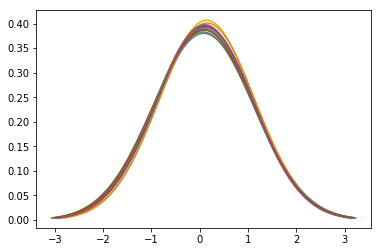

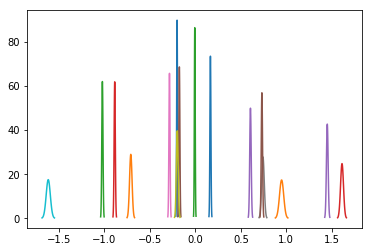

In [5160]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math


lat=8
for i in range(16):
    mu = latent_dist[0][i,lat].detach().numpy()
    variance = latent_dist[1][i,lat].exp().detach().numpy()
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    #plt.xlim([-2,2])
    plt.plot(x, stats.norm.pdf(x, mu, sigma))#, c = (labels[i,5].detach().numpy().tolist(),0.2,0.5))
plt.show()
lat=7
for i in range(16):
    mu = latent_dist[0][i,lat].detach().numpy()
    variance = latent_dist[1][i,lat].exp().detach().numpy()
    sigma = math.sqrt(variance)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))#, c = (labels[i,3].detach().numpy().tolist(),0.2,0.5))
plt.show()

In [5161]:
# print(latent_dist[1])

In [5162]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    #return fig

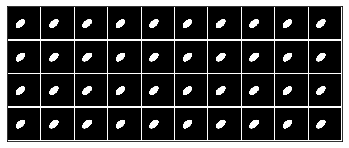

In [5163]:
samp = latent_sample[0]
s = samp.repeat(40,1)

b = torch.linspace(-3,3,40)
s[:,9] = b.view(40,)
show(vutils.make_grid(model.decode(s).cpu().data, pad_value=1,nrow=10))

# s = samp.repeat(10,1)

b = torch.linspace(-1,2,10)
s[:,9] = b.view(10,)
show(vutils.make_grid(model.decode(s).cpu().data, pad_value=1,nrow=10))

In [5164]:
# s = samp.repeat(40,1)
# s[:,4] = b.view(40,)
# show(vutils.make_grid(model.decode(s).cpu().data, pad_value=1))

In [5165]:
# s = samp.repeat(40,1)
# s[:,7] = b.view(40,)
# show(vutils.make_grid(model.decode(s).cpu().data, pad_value=1))

In [5166]:
# s = samp.repeat(40,1)
# s[:,9] = b.view(40,)
# show(vutils.make_grid(model.decode(s).cpu().data, pad_value=1))

In [5167]:
# import matplotlib.pyplot as plt
# lis = test_labels.detach().numpy()[:,-1].tolist()
# liss = [x/32 for x in lis]
# plt.scatter(latent_dist[0].detach().numpy(), np.zeros((32,)), 
#             c = liss)

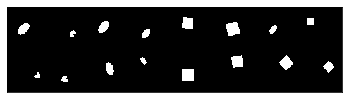

In [5168]:
show(vutils.make_grid(valid_originals.cpu()))

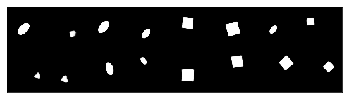

In [5169]:
show(vutils.make_grid(valid_reconstructions.cpu().data))

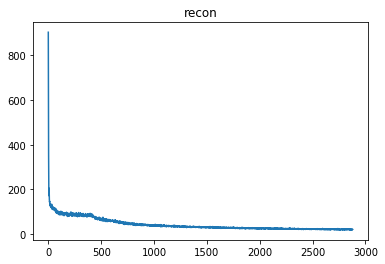

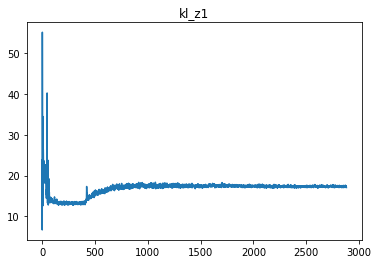

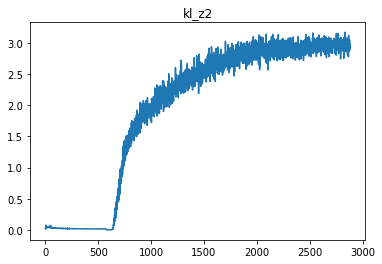

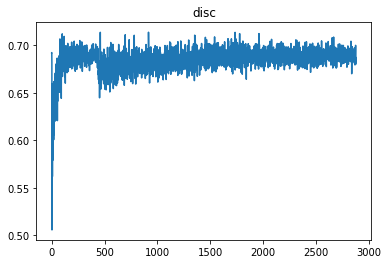

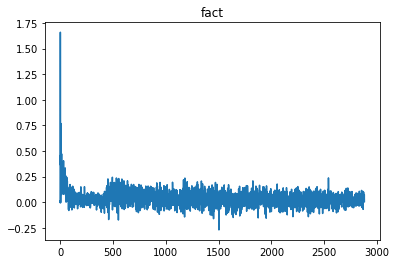

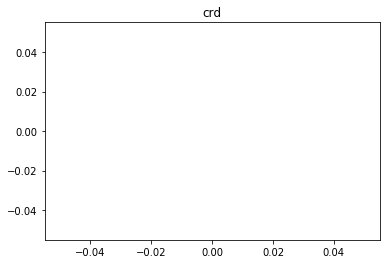

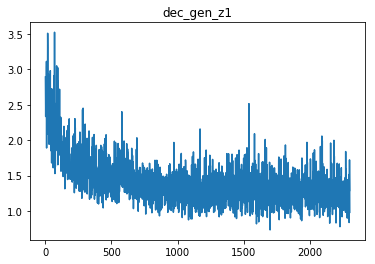

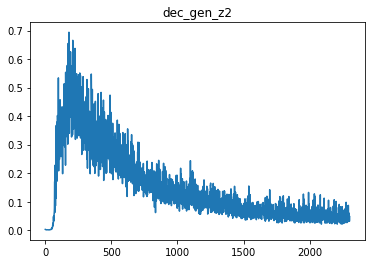

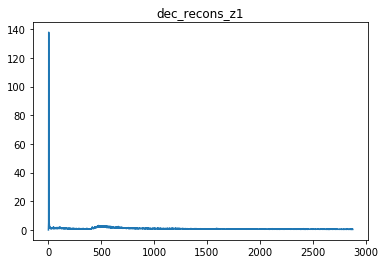

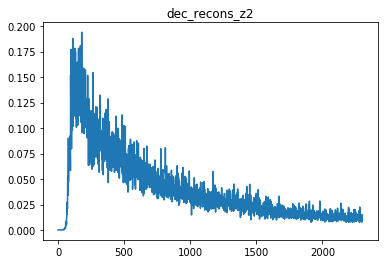

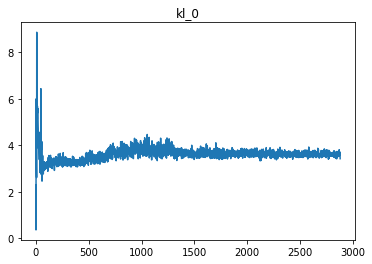

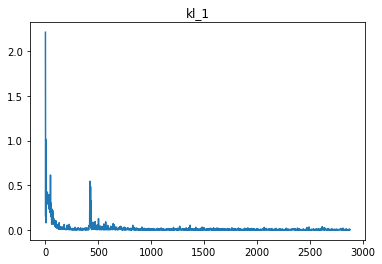

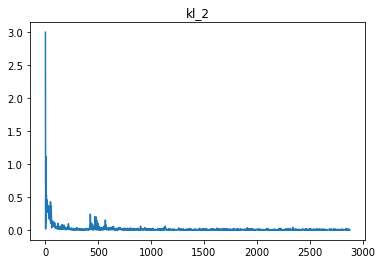

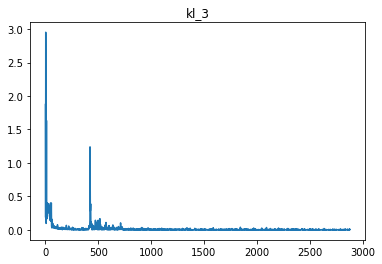

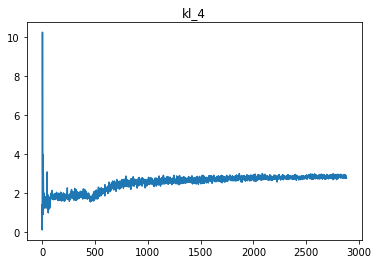

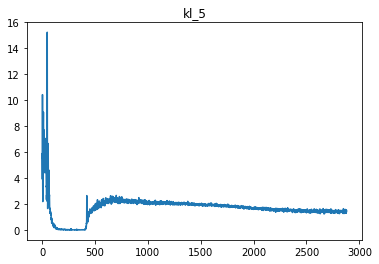

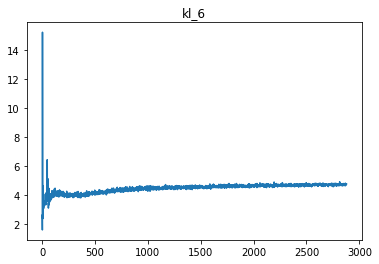

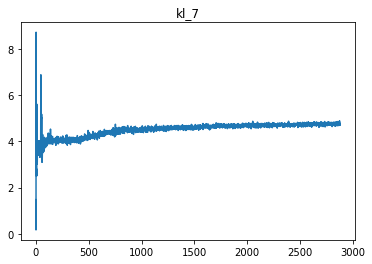

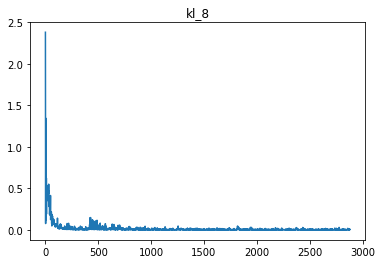

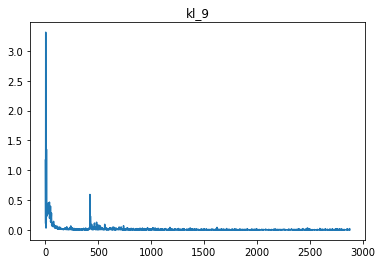

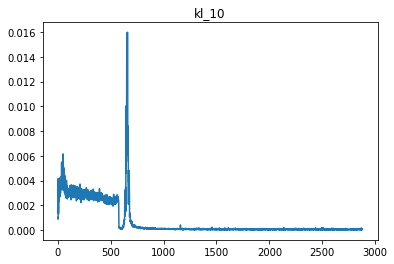

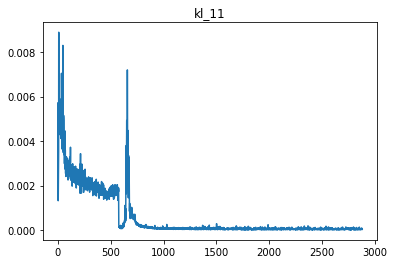

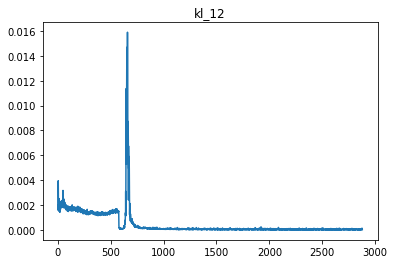

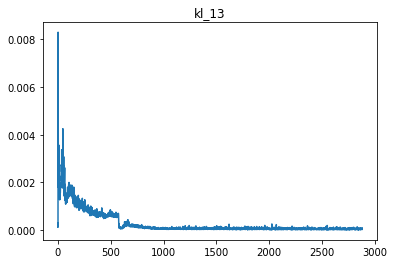

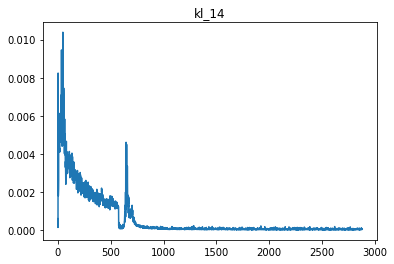

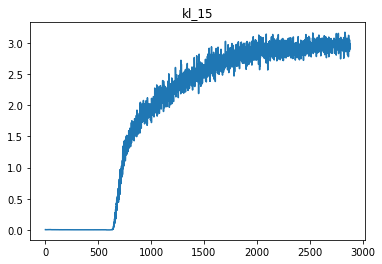

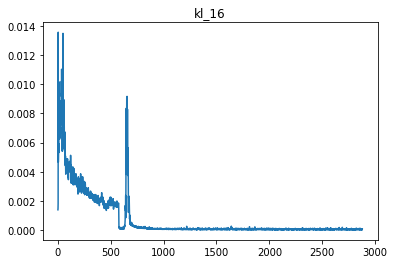

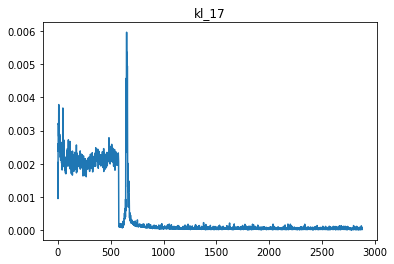

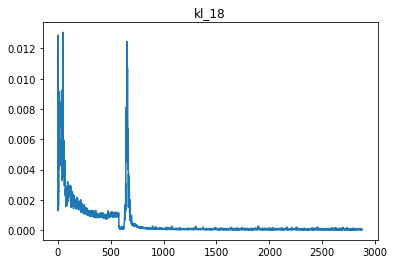

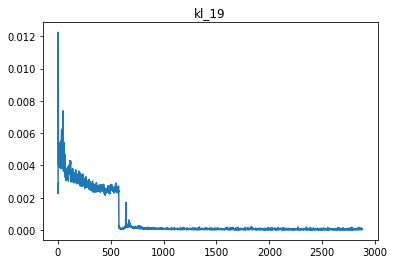

In [5170]:
import json
import matplotlib.pyplot as plt

with open(loss_file) as f:
    data = json.load(f)

for key in list(data):
    plt.plot(data[key])
    plt.title(key)
    plt.show()

In [5263]:
encoder_layer = nn.TransformerEncoderLayer(d_model=1, nhead=1, batch_first=True)
src = torch.rand(10, 32, 1)
out = encoder_layer(src)

TypeError: __init__() got an unexpected keyword argument 'batch_first'

In [5262]:
out.shape

torch.Size([10, 32, 1])

In [5264]:
import os

In [5265]:
os.path.join('results', 'dome')

'results/dome'